# 슈퍼바이저 에이전트(Supervisor Agent) 구축하기

**슈퍼바이저 패턴(Supervisor Pattern)** 은 **중앙 감독 에이전트(Supervisor Agent)** 가 여러 **전문 하위 에이전트(Worker Agents)** 를 조율하는 **멀티 에이전트 아키텍처**입니다.

이 접근 방식은 **서로 다른 전문 지식이 필요한 작업**을 수행할 때 특히 효과적입니다.
즉, 하나의 에이전트가 모든 도구 선택과 작업을 처리하는 대신, 각 분야별 **전문 에이전트(specialized agent)** 를 만들고,
**슈퍼바이저가 전체 워크플로우를 이해하고 관리**하도록 하는 구조입니다.

---

이 노트북에서는 이러한 장점을 보여주는 **워크플로우 기반의 개인 비서 시스템(personal assistant system)** 을 구축합니다.

역할이 근본적으로 다른 두 개의 전문가 에이전트를 조율합니다.

1. **캘린더 에이전트 (Calendar Agent)** : 일정 관리, 가용 시간 확인, 이벤트 생성 및 관리 담당  
2. **이메일 에이전트 (Email Agent)** : 커뮤니케이션 관리, 메일 초안 작성, 알림 발송 담당

## 왜 슈퍼바이저를 사용하는가?

멀티 에이전트 아키텍처는
**각 작업자(Worker)** 에이전트가 **자신만의 도구 세트와 프롬프트(지침)** 를 가지도록 역할을 분리(partition)할 수 있게 해줍니다.

예를 들어, 하나의 에이전트가 **캘린더 API** 와 **이메일 API** 모두에 직접 접근한다고 가정해봅시다.
이 경우 에이전트는 다음과 같은 문제를 동시에 해결해야 합니다.

* 여러 개의 **유사한 도구들** 중 어떤 것을 사용할지 결정해야 하고,
* 각 API의 **정확한 입력 형식(format)** 을 이해해야 하며,
* 서로 다른 **도메인(일정 관리, 이메일 통신 등)** 을 동시에 처리해야 합니다.

이처럼 복잡한 구조는 **성능 저하(performance degradation)** 를 초래할 수 있습니다.
이럴 때, 관련된 도구들과 프롬프트를 **논리적 그룹(logical group)** 으로 분리하는 것이 도움이 됩니다.
이 방식은 **유지보수 및 반복적 개선(iterative improvement)** 을 용이하게 하며,
각 하위 에이전트를 보다 **전문화된 형태로 최적화**할 수 있게 해줍니다.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-5-nano", model_provider="openai")
# model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

## 1. 도구 정의하기 (Define Tools)

먼저 **구조화된 입력(Structured Input)** 이 필요한 도구들을 정의합니다.
실제 애플리케이션에서는 이러한 도구들이 예를 들어 **Google Calendar**, **Notion** 등의 **실제 API** 를 호출하게 됩니다.

In [3]:
from langchain_core.tools import tool

@tool
def create_calendar_event(
    title: str,
    start_time: str,       # ISO 형식: "2024-01-15T14:00:00"
    end_time: str,         # ISO 형식: "2024-01-15T15:00:00"
    attendees: list[str],  # 참석자 이메일 주소 목록
    location: str = ""
) -> str:
    """캘린더 이벤트를 생성합니다. 정확한 ISO 날짜/시간 형식이 필요합니다."""
    # 실제로는 Google Calendar API, Outlook API 등을 호출합니다.
    return f"이벤트 생성 완료: {title}, {start_time} ~ {end_time}, 참석자 {len(attendees)}명"

@tool
def send_email(
    to: list[str],  # 수신자 이메일 주소 목록
    subject: str,   # 이메일 제목
    body: str,      # 이메일 본문
    cc: list[str] = []  # 참조(CC) 이메일 주소 목록
) -> str:
    """이메일 API를 통해 이메일을 전송합니다. 이메일 주소는 올바른 형식이어야 합니다."""
    # 실제로는 SendGrid, Gmail API 등을 호출합니다.
    return f"이메일 전송 완료 → 수신자: {', '.join(to)} | 제목: {subject}"

@tool
def get_available_time_slots(
    attendees: list[str],   # 참석자 이메일 목록
    date: str,              # ISO 형식 날짜: "2024-01-15"
    duration_minutes: int   # 회의 지속 시간(분 단위)
) -> list[str]:
    """지정된 날짜에 참석자들의 가능한 시간대를 확인합니다."""
    # 실제로는 Google Calendar 등의 캘린더 API를 조회합니다.
    return ["09:00", "14:00", "16:00"]

## 2. 전문 하위 에이전트(Sub-Agent) 생성하기

다음 단계에서는 **각 도메인별 작업을 담당하는 전문 하위 에이전트(Sub-Agent)** 를 만듭니다.

**캘린더 에이전트**는 사용자의 **자연어 일정 요청(natural language scheduling requests)** 을 정확한 **API 호출로 변환**하는 역할을 합니다.
즉, 사용자가 “내일 오후 2시에 회의 잡아줘”라고 말하면 이를 이해하고, ISO 형식의 API 호출로 변환하여 실제 일정 등록 작업을 수행합니다.

In [4]:
from langchain.agents import create_agent

CALENDAR_AGENT_PROMPT = (
    "당신은 캘린더 일정 관리 도우미입니다. "
    "사용자가 입력한 자연어 일정 요청(예: '다음 주 화요일 오후 2시')을 "
    "정확한 ISO 날짜·시간 형식으로 변환하세요. "
    "필요할 경우 get_available_time_slots 도구를 사용하여 참석자들의 가용 시간을 확인하고, "
    "create_calendar_event 도구를 사용해 일정을 등록하세요. "
    "마지막 응답에서는 반드시 어떤 일정이 등록되었는지 명확히 확인시켜 주세요."
)

calendar_agent = create_agent(
    model,
    tools=[create_calendar_event, get_available_time_slots],  # 사용할 도구 목록
    system_prompt=CALENDAR_AGENT_PROMPT,  # 에이전트의 역할 및 지침을 정의하는 시스템 프롬프트
)

- `calendar_agent` test

In [5]:
query = "다음 주 화요일 오후 2시에 1시간 동안 팀 회의를 일정에 추가해줘"

# 캘린더 에이전트를 스트리밍 모드로 실행
for step in calendar_agent.stream(
    {"messages": [{"role": "user", "content": query}]}
):
    # 각 단계(step)의 업데이트 내용을 순회
    for update in step.values():
        # 메시지가 존재할 경우 메시지들을 출력
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================

다음과 같이 해석했습니다:
- 제목: 팀 회의
- 일시(ISO): 2025-11-04T14:00:00+09:00 ~ 2025-11-04T15:00:00+09:00
  - “다음 주 화요일”은 2025-11-04로 해석했고, 시간대는 Asia/Seoul(UTC+9)로 가정했습니다.

등록을 위해 아래 정보 확인/추가 부탁드립니다:
1) 참석자 이메일 주소(예: a@company.com, b@company.com). 팀 메일링 리스트가 있으면 그걸로도 가능해요.
2) 시간대가 Asia/Seoul이 맞나요?
3) 장소 또는 화상회의 링크가 있나요?
4) 참석자들의 가용 시간 확인 후 빈 시간대로 잡을까요? 원하시면 확인해드릴게요(60분).


-------------------
**이메일 에이전트**는 메시지 작성 및 전송을 담당합니다.  
사용자가 “팀에게 회의 일정 공유 이메일 보내줘”라고 말하면, 이메일 에이전트는 수신자 목록을 추출하고, 자연스러운 제목과 내용을 자동으로 생성하여
**이메일 발송 프로세스 전체를 관리**합니다.

In [6]:
EMAIL_AGENT_PROMPT = (
    "당신은 이메일 작성 도우미입니다. "
    "사용자의 자연어 요청을 바탕으로 전문적인 이메일을 작성하세요. "
    "수신자 정보를 추출하고, 적절한 제목과 본문을 구성하세요. "
    "send_email 도구를 사용하여 메시지를 전송하세요. "
    "마지막 응답에서는 반드시 어떤 이메일이 발송되었는지 명확히 확인시켜 주세요."
)

email_agent = create_agent(
    model,
    tools=[send_email],              # 이메일 전송 도구 연결
    system_prompt=EMAIL_AGENT_PROMPT # 에이전트의 역할과 동작 지침을 정의하는 시스템 프롬프트
)

- email_agent test

In [7]:
query = "디자인 팀에게 새로운 프로토타입 검토에 대한 리마인더 메일을 보내줘"

# 이메일 에이전트를 스트리밍 모드로 실행
for step in email_agent.stream(
    {"messages": [{"role": "user", "content": query}]}
):
    # 각 단계(step)의 업데이트 내용을 순회
    for update in step.values():
        # 메시지가 존재할 경우 메시지들을 출력
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================

좋습니다. 바로 보내기 전에 몇 가지 정보가 필요해요:

- 받는 사람 이메일 주소(디자인 팀): 
- CC할 사람(있다면): 
- 검토 마감일: 
- 목업 링크나 첨부 파일 유무(링크/파일명): 
- 메일 톤(정중/캐주얼)과 제목 선호(있다면): 

아래와 같은 초안으로 보내드리면 될까요? 확인 후 수신자 정보와 함께 “보내기”라고 알려주시면 즉시 발송하겠습니다.

제목: [리마인더] 새로운 목업 검토 요청 (마감: YYYY-MM-DD)

본문:
안녕하세요, 디자인 팀 여러분.

지난주 공유드린 새로운 목업에 대한 검토를 부탁드립니다. 원활한 일정 진행을 위해 아래 일정까지 피드백을 회신해 주시면 감사하겠습니다.

- 검토 대상: [프로젝트/화면명 요약]
- 목업 링크: [링크]
- 요청 사항: 기능 흐름, 시각적 일관성, 반응형 대응, 접근성 체크
- 피드백 마감: YYYY-MM-DD(요일) EOD
- 회신 방식: 본 메일 회신 또는 [협업툴/보드명] 코멘트

추가 논의가 필요하시면 간단한 싱크 미팅도 잡겠습니다. 확인과 검토에 미리 감사드립니다.

감사합니다.
[보내는 사람 이름/직책]
[연락처]


## 3. 하위 에이전트를 도구로 감싸기 

이제 각 **하위 에이전트(Sub-Agent)** 를 **슈퍼바이저(Supervisor)** 가 호출할 수 있는 **도구(Tool)** 형태로 감쌉니다.  
이 단계가 바로 **계층형 시스템(layered system)** 을 만드는 핵심 아키텍처 단계입니다.  

슈퍼바이저는 더 이상 세부적인 하위 함수(`create_calendar_event` 등)를 직접 호출하지 않습니다.  
대신, **고수준 도구(high-level tools)** — 예를 들어 `"schedule_event"` 또는 `"send_email"` 과 같은 추상화된 명령을 사용할 수 있습니다.

In [8]:
@tool
def schedule_event(request: str) -> str:
    """자연어 요청을 기반으로 캘린더 이벤트를 예약합니다.

    사용자가 일정(예: 회의, 약속 등)을 생성하거나 수정하거나
    확인하고자 할 때 이 도구를 사용하세요.
    날짜/시간 파싱, 가용 시간 확인, 이벤트 생성을 자동으로 처리합니다.

    입력값: 자연어 일정 요청 (예: '다음 주 화요일 오후 2시에 디자인 팀과 회의 잡아줘')
    """
    result = calendar_agent.invoke({
        "messages": [{"role": "user", "content": request}]
    })
    return result["messages"][-1].text


@tool
def manage_email(request: str) -> str:
    """자연어 요청을 기반으로 이메일을 전송합니다.

    사용자가 알림, 리마인더 또는 일반 이메일 커뮤니케이션을
    전송하고자 할 때 이 도구를 사용하세요.
    수신자 추출, 제목 생성, 이메일 본문 작성 과정을 자동으로 처리합니다.

    입력값: 자연어 이메일 요청 (예: '회의에 대해 리마인더 이메일 보내줘')
    """
    result = email_agent.invoke({
        "messages": [{"role": "user", "content": request}]
    })
    return result["messages"][-1].text

도구의 **설명(Description)** 은 슈퍼바이저가 **언제 어떤 도구를 사용할지 결정**하는 데 도움을 줍니다.
따라서 설명은 **명확하고 구체적**이어야 합니다.

또한, 하위 에이전트의 실행 결과 중에서 **최종 응답(final response)** 만 반환하도록 해야 합니다.
슈퍼바이저는 하위 에이전트의 **중간 추론(reasoning)** 이나 **도구 호출 과정(tool calls)** 을 볼 필요가 없기 때문입니다.

---

## 4. 슈퍼바이저 에이전트 생성하기

이제 여러 하위 에이전트를 **조율(orchestrate)** 하는 **슈퍼바이저(Supervisor Agent)** 를 만듭니다.

슈퍼바이저는 다음과 같은 방식으로 작동합니다.

* 하위 에이전트들이 제공하는 **고수준 도구(high-level tools)** 만 인식합니다.
* **도메인 단위(domain-level)** 에서 라우팅 결정을 내리며, 세부적인 API 호출 수준의 작업은 직접 다루지 않습니다.

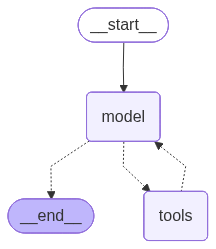

In [9]:
SUPERVISOR_PROMPT = (
    "당신은 친절한 개인 비서입니다. "
    "캘린더 일정을 등록하고 이메일을 보낼 수 있습니다. "
    "사용자의 요청을 적절한 도구 호출로 분해하고, 그 결과를 조율하세요. "
    "요청에 여러 작업이 포함되어 있다면, 여러 도구를 순차적으로 사용하세요."
)

supervisor_agent = create_agent(
    model,
    tools=[schedule_event, manage_email],   # 슈퍼바이저가 사용할 상위 도구 목록
    system_prompt=SUPERVISOR_PROMPT,       # 에이전트의 역할과 행동 지침을 정의하는 시스템 프롬프트
)
supervisor_agent

## 5. Supervisor 사용
여러 도메인 간 조율이 필요한 복합 요청으로 완성된 시스템 테스트

### 예시 1: 단일 도메인 요청 (Simple Single-Domain Request)
- 일정 관리(Calendar) 도메인만 포함 → schedule_event 도구만 사용

In [10]:
query = "내일 오전 9시에 팀 스탠드업 미팅을 일정에 추가해줘"

# 슈퍼바이저 에이전트를 스트리밍 모드로 실행
for step in supervisor_agent.stream(
    {"messages": [{"role": "user", "content": query}]}
):
    # 각 단계(step)의 업데이트 내용을 순회
    for update in step.values():
        # 메시지가 존재할 경우 메시지들을 출력
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  schedule_event (call_pwb9bEIanOen4Zzvhu8OEOUW)
 Call ID: call_pwb9bEIanOen4Zzvhu8OEOUW
  Args:
    request: 내일 오전 9시에 팀 스탠드업 미팅을 일정에 추가해줘
================================= Tool Message =================================
Name: schedule_event

다음 일정으로 등록했습니다.
- 제목: 팀 스탠드업 미팅
- 시간: 2025-10-29T09:00:00 ~ 2025-10-29T09:15:00
- 참석자: 없음
- 장소: 미지정

참석자를 추가하거나 시간/기간을 변경할까요?
================================== Ai Message ==================================

일정을 추가했어요.
- 제목: 팀 스탠드업 미팅
- 시간: 10월 29일(수) 오전 9:00–9:15
- 참석자: 없음
- 장소: 미정

참석자 추가, 화상 회의 링크(예: Google Meet) 첨부, 알림 설정, 또는 평일 반복으로 설정할까요?


-----------------
### 예시 2: 복합 다중 도메인 요청 (Complex Multi-Domain Request)

- 두 개의 도메인 작업이 결합
    - 일정 관리 (Calendar)
    - 이메일 발송 (Email)

Supervisor가 2개의 도구를 순차적으로 호출해야 함: schedule_event → manage_email

In [11]:
query = (
    "다음 주 화요일 오후 2시에 디자인 팀과 1시간짜리 회의를 잡고, "
    "새로운 목업 검토에 대한 리마인더 이메일을 함께 보내줘."
)

# 슈퍼바이저 에이전트를 스트리밍 모드로 실행
for step in supervisor_agent.stream(
    {"messages": [{"role": "user", "content": query}]}
):
    # 각 단계(step)의 업데이트 내용을 순회
    for update in step.values():
        # 메시지가 존재할 경우 메시지들을 출력
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  schedule_event (call_mIkGwkrFnp9D0bwTpszaylDE)
 Call ID: call_mIkGwkrFnp9D0bwTpszaylDE
  Args:
    request: 다음 주 화요일 오후 2시에 디자인 팀과 1시간짜리 회의 잡아줘. 회의 제목은 '새로운 목업 검토'로 해줘. 설명에 주요 안건: 새로운 목업 검토라고 적어줘.
  manage_email (call_hSlsmSiZcCQ2hhA1ElMZTnP0)
 Call ID: call_hSlsmSiZcCQ2hhA1ElMZTnP0
  Args:
    request: 디자인 팀에게 새로운 목업 검토에 대한 리마인더 이메일을 보내줘. 다음 주 화요일 오후 2시에 1시간짜리 회의가 예정되어 있다고 안내하고, 사전에 확인해야 할 목업 링크나 관련 자료가 있으면 미리 공유해달라고 요청해줘. 회의 세부정보(일시, 제목)를 본문에 명확히 포함해줘.
================================= Tool Message =================================
Name: manage_email

보낼 이메일 초안을 준비했습니다. 수신자 이메일 주소(예: design-team@회사도메인.com)와 CC 대상이 있으면 알려주세요. 서명에 넣을 발신자명/직책도 함께 알려주시면 반영하겠습니다.

[제목]
리마인더: 새로운 목업 검토 회의 — 11월 4일(화) 오후 2:00–3:00

[본문]
디자인 팀 여러분께,

새로운 목업 검토 관련하여 리마인더 드립니다.

회의 세부정보
- 제목: 새로운 목업 검토 미팅
- 일시: 2025년 11월 4일(화) 오후 2:00–3:00 (1시간)

사전에 확인이 필요한 목업 링크나 관련 자료가 있으시면, 원활한 논의를 위해 회의 전에 미리 공유 부탁드립니다.

감사합니다.


-------------------
### 아키텍처 이해하기 

이 시스템은 **3계층 구조(three-layer architecture)** 로 이루어져 있습니다.

1. 하위 계층 (Bottom Layer)

* **정확한 형식(exact formats)** 을 요구하는 **고정형 API 도구(rigid API tools)** 로 구성됩니다.
* 예: `create_calendar_event`, `send_email` 등
* 이 계층은 실제 외부 서비스(API)와 직접 상호작용합니다.

2. 중간 계층 (Middle Layer)

* **하위 에이전트(Sub-Agents)** 가 존재하는 계층입니다.
* 사용자의 **자연어 입력(natural language)** 을 받아
  이를 **구조화된 API 호출(Structured API Calls)** 로 변환한 뒤,
  다시 **자연어 응답(natural language confirmations)** 형태로 반환합니다.
* 예: `calendar_agent`, `email_agent`

3. 상위 계층 (Top Layer)

* **슈퍼바이저(Supervisor Agent)** 가 위치한 계층입니다.
* 하위 에이전트들을 조율하며, **고수준 명령(high-level capabilities)** 을 인식하고
  각 도메인별로 요청을 **라우팅(routing)** 합니다.
* 또한 여러 하위 작업의 결과를 **통합(synthesize)** 하여 사용자에게 제공합니다.